# Homework 2, Machine Learning 1
#### Problem 1: Logistic Regression

Given the dataset $\{\phi_n, t_n\}$, with $t_n \in \{0, 1\}$ and design matrix $\phi_n = \phi(x_n)$, minimize the cross-entropy error:

$$
E(w) = -\ln p(\boldsymbol{t}|w) = -\sum_{n=1}^N t_n \ln y_nn + (1 - t_n)\ln(1 - y_n)
$$

where $y_n = \sigma(a_n)$ and $a_n \boldsymbol{w}^T \phi_n$. Taking the gradient with respect to $\boldsymbol{w}$, we have

$$
\nabla E(\boldsymbol{w}) = \sum_{n=1}^N (y_n - t_n) \phi_n
$$

This is the exact same gradient as the sum of squares error function for the linear regression model.

In [1]:
from numpy.random import choice
from numpy import matmul
from numpy import zeros
from numpy import ones
from numpy import exp


class LogisticRegression:
    """
    Binary logistic regression classifier with stochastic gradient descent optimizer
    """
    def __init__(self, X, y) -> None:
        # data
        self.X = X
        # target
        self.y = y
        # data dimensions
        self.n = X.shape[0]
        self.d = X.shape[1]
        # probabilities
        self.p = zeros(len(y))
        self.p[y == 0] = (y == 0).sum()/len(y)
        self.p[y == 1] = (y == 1).sum()/len(y)
        # weights
        self.w = ones(self.d)

    def update_weights(self, i):
        """
        Update weight for a point x
        """
        # variance
        R = self.p[i] * (1 - self.p[i])
        # effective target value
        z = (self.X[i, :] * self.w).sum() - (1/R) * (self.p[i] - self.y[i])

        self.w = self.X[i, :] * z/(self.X[i, :] * self.X[i, :]).sum()

    def fit(self, max_iter):
        """
        fit model to data using stochastic gradient descent
        """
        # start training
        for _ in range(max_iter):
            # randomly sample point
            i = choice(self.n)
            # update weights
            self.update_weights(i)

    def predict_proba(self, X):
        """
        following fit, return predictions probabilities given by sigmoid function
        """
        return 1/(1 - exp(matmul(X, self.w)))

    def predict_class(self, X):
        """
        Assign class to instances using predicted probabilites
        :return:
        """
        probs = self.predict_proba(X)
        return (probs >= 0.5).astype(int)



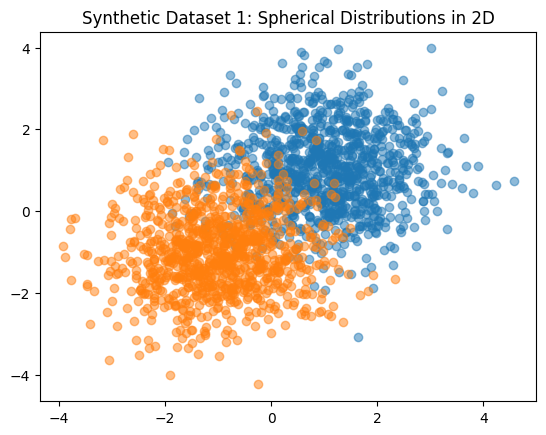

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# set seed
np.random.seed(143)

# multivariate normal data in 2d
size = 1000
data1 = np.random.multivariate_normal([1, 1], np.identity(2), size=size)
data2 = np.random.multivariate_normal([-1, -1], np.identity(2), size=size)

# plot
fig, ax = plt.subplots()

ax.scatter(data1[:, 0], data1[:, 1], alpha=0.5)
ax.scatter(data2[:, 0], data2[:, 1], alpha=0.5)

ax.set_title('Synthetic Dataset 1: Spherical Distributions in 2D')

plt.show()

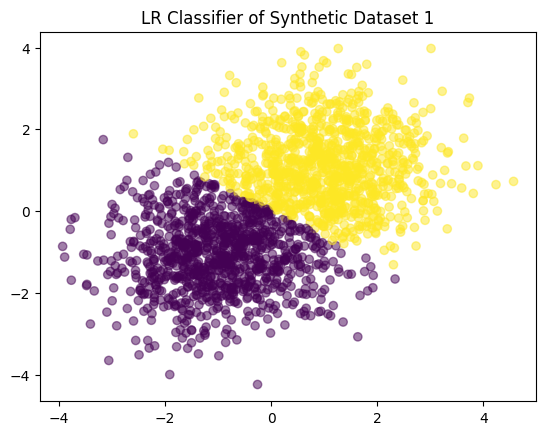

In [20]:
#from hw2lr import LogisticRegression

# prep data
X = np.concatenate([data1, data2], axis=0)
y = np.array([0]*size + [1]*size)

lr = LogisticRegression(X=X, y=y)
lr.fit(max_iter=10000)

# get predictions
y_predict_proba = lr.predict_proba(X)
y_predict = lr.predict_class(X)

# plot results
plt.scatter(X[:, 0], X[:, 1], c=y_predict, alpha=0.5)
plt.title('LR Classifier of Synthetic Dataset 1')
plt.show()

# Problem 2: Checkerboard data

In [8]:
# generate checker board data
def gen_cb(N, a, alpha):
    """
    N: number of points on the checkerboard
    a: width of the checker board (0<a<1)
    alpha: rotation of the checkerboard in radians
    """
    d = np.random.rand(N, 2).T
    d_transformed = np.array([d[0]*np.cos(alpha)-d[1]*np.sin(alpha),
    d[0]*np.sin(alpha)+d[1]*np.cos(alpha)]).T
    s = np.ceil(d_transformed[:,0]/a)+np.floor(d_transformed[:,1]/a)
    lab = 2 - (s%2)
    data = d.T
    return data, lab

Sample points from the above generator and visualize distribution:

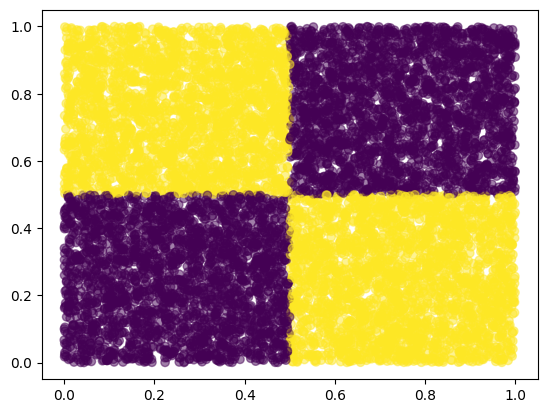

In [189]:
N = 10000
X, y = gen_cb(N=N, a=0.5, alpha=0)

plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.5)
plt.show()

Plot posterior probability when class == 1:

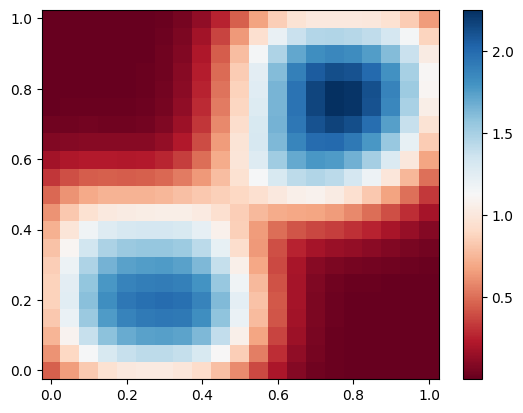

In [166]:
N = 1000
X, y = gen_cb(N=N, a=0.5, alpha=0)

# look only at data points associated with class c = 1
c = 1
X = X[y == c]

N = X.shape[0]
D = X.shape[1]
h = 0.1

# make these smaller to increase the resolution
dx, dy = 0.05, 0.05

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(0, 1 + dy, dy),
                slice(0, 1 + dx, dx)]

# compute gaussian histogram
z = 0
for i in range(N):
    z += (1/(2*np.pi*h**2))**(D/2)*np.exp(-1*((x - X[i, 0])**2 + (y - X[i, 1])**2)/(2*h**2))

# normalize
z = z/N

# plot results
plt.pcolor(x, y, z, cmap='RdBu')
plt.colorbar()
plt.show()

Use Parzen window with Guassian kernel function to classifiy datapoints:

In [187]:
from numpy import argmax
from numpy.linalg import norm

class GaussainKernel():
    """
    Gaussian kernel density estimator.
    """
    def __init__(self, h):
        # gaussian variance
        self.h = h

    def fit(self, X_train, y_train):
        """
        Fit model to training set
        :param X_train: training data
        :param y_train: training labels
        :return: None
        """
        self.X_train = X_train
        self.y_train = y_train

    def get_likelihood(self, X_test, c):
        """
        likelihood of assigning points in X_test to c given X_train
        :param c: training set class
        :param X_test: test data
        :return: likelihood 
        """
        # get training data corresponding to class c
        X_train = self.X_train[self.y_train == c]
        # shape parameters
        N = X_train.shape[0]
        D = X_train.shape[1]
        # compute likelihood
        z = 0
        for i in range(N):
            z += (1/(2*np.pi*self.h**2))**(D/2)*np.exp(-1*norm(X_test - X_train[i, :], axis=1)/(2*self.h**2))

        # normalize and return
        return z/N

    def predict(self, X_test):
        """
        Train a parzen model
        :param X_test: test data
        :return: classification of points in X_test
        """
        N = X_test.shape[0]
        D = X_test.shape[1]
        post_proba = []
        for c in np.unique(self.y_train):
            # compute prior
            prior = (y == c).sum()/len(y)
            # compute likelihood
            likelihood = self.get_likelihood(X_test=X_test, c=c)
            # compute posterior
            post_proba.append(prior*likelihood)

        return argmax(np.array(post_proba).T, axis=1)

Apply gaussian density estimator to the test set:

Parzen Window Density Estimator Test Accuracy: 0.9955


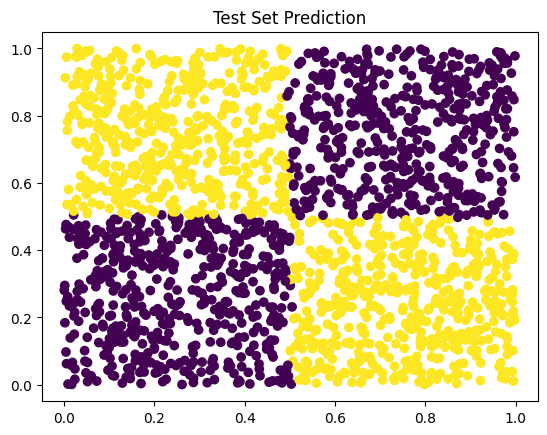

In [194]:
N = 10000
X, y = gen_cb(N=N, a=0.5, alpha=0)

# split data into 20% test and 80% train
k = int(0.80 * N)
X_train = X[:k, :]
y_train = y[:k]
X_test = X[k:, :]
y_test = y[k:]

# instantiate classifier
h = 0.1
clf = GaussainKernel(h=h)
# fit model
clf.fit(X_train, y_train)
# predict test labels
y_predict = clf.predict(X_test)

# print accuracy
print('Parzen Window Density Estimator Test Accuracy:', (y_predict + 1 == y_test).sum()/len(y_test))

# plot results
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_predict)
plt.title('Test Set Prediction')
plt.show()